In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from small_script.myFunctions import *
import feather
import Bio.PDB as bio

from sklearn.metrics import confusion_matrix


d3_to_index = bio.Polypeptide.d3_to_index  # we may want to adjust this in the future.
three_to_one = bio.Polypeptide.three_to_one
one_to_index = bio.Polypeptide.one_to_index

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [16.18033, 10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras.utils import to_categorical

from keras.models import model_from_json

from keras.metrics import top_k_categorical_accuracy

max_features = 20
batch_size = 1024*2
maxlen = 9
n = int(1e4)


Using TensorFlow backend.


In [ ]:
def getFrags(pdb):
    seqFile = f"/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/all_simulations/{pdb}/{pdb}/{pdb}.seq"
    with open(seqFile) as f:
        lines = f.readlines()
    a = lines[0].strip()
    all_frag = []
    for i in range(0, len(a)-8):
        frag = a[i:i+9]
        # print(frag)
        fragIndex = [one_to_index(x) for x in frag]
        # print(fragIndex)
        all_frag.append(fragIndex)
    all_frag = np.array(all_frag)
    predicted_cluster = loaded_model.predict_classes(all_frag)
    pre = "/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/fragment_memory/"
    header = '''\
[Target]
query

[Memories]
'''
    with open(pre+f"{pdb}.mem", "w") as out:
        out.write(header)
        for index, i in enumerate(predicted_cluster):
            out.write(f"fraglib/{i}.gro {index+1} 1 9 20\n")



In [222]:
def getFrags(pdb, toLocation, top_n=1, evenWeight=True):
    seqFile = f"/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/all_simulations/{pdb}/{pdb}/{pdb}.seq"
    with open(seqFile) as f:
        lines = f.readlines()
    a = lines[0].strip()
    all_frag = []
    for i in range(0, len(a)-8):
        frag = a[i:i+9]
        # print(frag)
        fragIndex = [one_to_index(x) for x in frag]
        # print(fragIndex)
        all_frag.append(fragIndex)
    all_frag = np.array(all_frag)
    predict_prob = loaded_model.predict(all_frag)
    clusters = np.argsort(-predict_prob)[:, :top_n]
    n = predict_prob.shape[0]
    prob = predict_prob[np.arange(n).reshape(n,1), clusters]
    prob /= (prob.sum(axis=1)).reshape(n,1)
    # pre = "/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/fragment_memory/"
    pre = toLocation
    header = '''\
[Target]
query

[Memories]
'''
    with open(pre+f"{pdb}.mem", "w") as out:
        out.write(header)
        if evenWeight:
            weight = 20/top_n
        for index, c in enumerate(clusters):
            for index2, i in enumerate(c):
                if not evenWeight:
                    weight = prob[index][index2]
                out.write(f"fraglib/{i}.gro {index+1} 1 9 {weight:.3}\n")

In [4]:
json_file = open("/Users/weilu/Research/optimization/fragment/lstm100/model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/Users/weilu/Research/optimization/fragment/lstm100/model.h5")

In [7]:
pre = "/Users/weilu/Research/optimization/fragment/lstm100/"
x_train = np.load(pre+"trainX.npy")
y_train = np.load(pre+"trainY.npy")
x_test = np.load(pre+"testX.npy")
y_test = np.load(pre+"testY.npy")

In [97]:
loaded_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [137]:
loaded_model.evaluate(x_test, y_test)

1000000/1000000 [==============================] - 70s 70us/step


[3.547358810791254, 0.185256, 0.32267, 0.405813, 0.539875, 0.693226]

In [118]:
loaded_model.predict_classes(x_test[:10])

array([13, 69, 45, 40, 45, 95, 32, 19, 70, 21])

In [179]:
predict_prob = loaded_model.predict(x_test[:10])
clusters = np.argsort(-predict_prob)[:, :top_n]
loaded_model.evaluate(x_test[:10], y_test[:10])

10/10 [==============================] - 0s 189us/step


[4.3088274002075195, 0.0, 0.0, 0.0, 0.20000000298023224, 0.6000000238418579]

In [185]:
np.arange(10).T

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [182]:
clusters

array([[13, 70, 37, 96, 79],
       [69,  6, 39, 73, 31],
       [45, 39, 96, 15, 74],
       [40, 84, 48, 22, 63],
       [45, 58, 74, 29, 39],
       [95, 66, 76, 98, 63],
       [32, 11,  5, 86, 93],
       [19,  4, 23, 97, 52],
       [70, 87, 37, 32,  6],
       [21,  4, 58, 72, 19]])

In [135]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)
def top_10_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10)
def top_20_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=20)

In [136]:
loaded_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy', top_3_accuracy, top_5_accuracy, 
                                                                  top_10_accuracy, top_20_accuracy])

In [223]:
pdb_list = "1FC2C, 1ENH, 2GB1, 2CRO, 1CTF, 4ICB".split(", ")
pre = "/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/fragment_memory_top5_noeven/"
for p in pdb_list:
    name = p.lower()[:4]
    getFrags(name, pre, top_n=5, evenWeight=False)

In [ ]:
top_k_categorical_accuracy()

In [59]:
seqFile = "/Users/weilu/Research/optimization/fragment/1ctf.seq"
with open(seqFile) as f:
    lines = f.readlines()

In [63]:
a = lines[0].strip()

In [69]:
a

'EFDVILKAAGANKVAVIKAVRGATGLGLKEAKDLVESAPAALKEGVSKDDAEALKKALEEAGAEVEVK'

In [79]:
all_frag = []
for i in range(0, len(a)-8):
    frag = a[i:i+9]
    # print(frag)
    fragIndex = [one_to_index(x) for x in frag]
    # print(fragIndex)
    all_frag.append(fragIndex)
all_frag = np.array(all_frag)
# print(all_frag)
loaded_model.predict_classes(all_frag)

array([ 1, 25, 21, 26, 16, 38, 40, 65, 51, 85, 25, 17, 56,  4, 21, 26, 79,
       21, 96, 90, 83, 23, 38, 13, 11, 80, 84, 32, 80,  1, 67, 27, 95, 98,
       75, 11, 80, 21, 26, 16, 46, 23, 75, 13, 11, 80, 78, 32, 80,  1,  1,
        1,  1, 54, 21, 26, 16, 46, 61,  2])

In [85]:
predicted_cluster = loaded_model.predict_classes(all_frag)

In [88]:
pre = "/Users/weilu/Research/optimization/fragment/"
header = '''\
[Target]
query

[Memories]
'''
with open(pre+"frags.mem", "w") as out:
    out.write(header)
    for index, i in enumerate(predicted_cluster):
        out.write(f"fraglib/{i}.gro {index+1} 1 9 20\n")
        

In [81]:
len(loaded_model.predict_classes(all_frag))

60

In [21]:
y_train[2]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [17]:
np.argwhere(y_train[:,1] == 1)

array([[10000],
       [10001],
       [10002],
       ...,
       [19997],
       [19998],
       [19999]])

In [76]:
all_frag.shape

(60, 9)

In [77]:
x_train[0:2]

array([[ 6,  9, 19,  7,  3,  3,  5, 14, 16],
       [ 8,  4,  9, 19, 11,  2, 11,  5,  8]])

In [38]:
loaded_model.predict(x_train[10001:10004, :]).round(2)

array([[0.  , 0.06, 0.  , 0.09, 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  ,
        0.01, 0.  , 0.  , 0.01, 0.  , 0.06, 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.  ,
        0.  , 0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.01, 0.09, 0.  , 0.  , 0.  , 0.01, 0.  , 0.05,
        0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.11, 0.01, 0.  ,
        0.06, 0.01, 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.07, 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01,
        0.  ],
       [0.  , 0.22, 0.01, 0.04, 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  ,
        0.04, 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.05,
        0.  , 0.  , 0.01, 0.01, 0.  , 0.08, 0.  , 0.01, 0.  , 0.01, 0.02,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0. 

In [39]:
loaded_model.predict_classes(x_train[10001:20000, :])

array([63,  1,  1, ..., 78,  1, 56])

(array([550., 111., 457.,  86.,  52., 149., 122., 326., 212., 243., 338.,
        178.,  58., 213., 485., 162., 166., 127., 135., 184.,  67., 366.,
        466., 104.,  40.,  49., 143.,  89., 100., 690., 207.,  57., 234.,
        110., 259., 195., 189., 427., 129., 252.,  69., 119., 111.,  80.,
        136.,  75., 292., 214., 299.,  78.]),
 array([ 0.  ,  1.98,  3.96,  5.94,  7.92,  9.9 , 11.88, 13.86, 15.84,
        17.82, 19.8 , 21.78, 23.76, 25.74, 27.72, 29.7 , 31.68, 33.66,
        35.64, 37.62, 39.6 , 41.58, 43.56, 45.54, 47.52, 49.5 , 51.48,
        53.46, 55.44, 57.42, 59.4 , 61.38, 63.36, 65.34, 67.32, 69.3 ,
        71.28, 73.26, 75.24, 77.22, 79.2 , 81.18, 83.16, 85.14, 87.12,
        89.1 , 91.08, 93.06, 95.04, 97.02, 99.  ]),
 <a list of 50 Patch objects>)

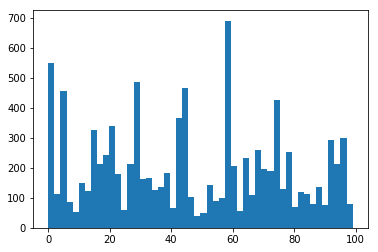

In [43]:
plt.hist(loaded_model.predict_classes(x_train[:10000, :]), bins=50)

In [48]:
df = pd.DataFrame({'data':loaded_model.predict_classes(x_train[:10000, :])})
print(df['data'].value_counts().head())

58    547
0     445
45    366
74    359
28    338
Name: data, dtype: int64


In [47]:
df = pd.DataFrame({'data':loaded_model.predict_classes(x_train[10001:20000, :])})
print(df['data'].value_counts().head())

1     2611
54     470
80     405
72     402
3      392
Name: data, dtype: int64


In [55]:
np.all(loaded_model.predict(x_train[10001:20000, :]).round(2) == loaded_model.predict_proba(x_train[10001:20000, :]).round(2))

True

In [57]:
loaded_model.predict(x_train[10002].reshape(1,9)).round(2)

array([[0.  , 0.22, 0.01, 0.04, 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  ,
        0.04, 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.05,
        0.  , 0.  , 0.01, 0.01, 0.  , 0.08, 0.  , 0.01, 0.  , 0.01, 0.02,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.11,
        0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01,
        0.01, 0.03, 0.  , 0.02, 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01,
        0.  , 0.01, 0.  , 0.02, 0.  , 0.02, 0.  , 0.  , 0.01, 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ,
        0.  ]], dtype=float32)

In [25]:
loaded_model.predict(x_train[10001].reshape(1,-1))

array([[1.94163201e-03, 5.72058335e-02, 3.49636818e-03, 8.66604224e-02,
        3.45707545e-03, 2.18330737e-04, 9.23126529e-04, 1.06004775e-02,
        1.06848951e-03, 6.80391304e-03, 8.49636039e-04, 5.14316978e-03,
        5.12195111e-04, 2.44294875e-03, 6.44069584e-03, 2.51834490e-03,
        5.91256283e-02, 7.19474256e-03, 1.38767750e-03, 1.88106555e-03,
        2.71060248e-03, 3.22767720e-03, 3.61111853e-03, 4.47409088e-03,
        2.90813716e-03, 3.80009576e-03, 1.00325020e-02, 7.80387037e-03,
        6.22312305e-04, 1.90860615e-03, 8.61866213e-03, 1.83285959e-03,
        1.83846429e-03, 6.52538205e-04, 2.33797394e-02, 1.36588479e-03,
        6.12687180e-03, 1.02770468e-02, 7.04589358e-04, 1.40654051e-03,
        4.55599511e-03, 1.32390894e-02, 5.79965650e-04, 8.40307097e-04,
        4.93463944e-04, 1.28919477e-04, 5.48354723e-03, 5.70566161e-03,
        9.31848362e-02, 4.84534297e-08, 3.01808957e-03, 1.45387277e-03,
        1.09089846e-02, 4.58485028e-03, 5.19727282e-02, 1.806793

In [13]:
loaded_model.predict(x_train[0].reshape(1,-1))

array([[4.01732400e-02, 1.69577741e-03, 9.31578863e-04, 6.02654042e-03,
        2.79191788e-02, 5.37388446e-03, 2.46933708e-03, 6.26293186e-04,
        2.28643906e-03, 2.71171506e-04, 5.15630119e-04, 1.07777992e-03,
        2.43215403e-03, 1.25367625e-03, 2.61013559e-03, 7.90676549e-02,
        6.84397179e-04, 4.37424937e-03, 3.29821691e-04, 3.27693187e-02,
        2.87527661e-03, 4.19266755e-03, 1.07942172e-03, 1.31846359e-03,
        1.09363990e-02, 6.94359234e-03, 9.84150693e-02, 7.97016174e-03,
        7.58362710e-02, 1.56424951e-03, 3.72109488e-02, 1.14058200e-02,
        8.15052481e-04, 4.24836995e-04, 3.60342301e-03, 5.73986035e-04,
        8.73260724e-04, 7.17182935e-04, 1.43264467e-03, 5.70024690e-03,
        5.57794760e-04, 7.73043255e-04, 1.49696376e-02, 1.13147400e-01,
        1.69002183e-03, 5.74871758e-03, 6.21584360e-04, 2.30530072e-02,
        7.12187961e-04, 3.98535803e-06, 4.33705514e-03, 2.67115724e-03,
        1.87868334e-03, 1.90732593e-03, 3.12483124e-03, 4.928888

In [6]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 20)             400       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               152576    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
Total params: 178,676
Trainable params: 178,676
Non-trainable params: 0
_________________________________________________________________
